In [0]:
from __future__ import print_function
#import tensorflow as tf
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None) 

In [6]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
batch_size = 64  # Batch size for training.
epochs = 70  # Number of epochs to train for.
latent_dim = 512  # Latent dimensionality of the encoding space.
num_samples = 7000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'cleaned_data.txt'

In [8]:
# Vectorize the data.
input_texts = []
target_texts = []
input_words = set()
target_words = set()

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    index, input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = 'START_ '+target_text+ ' _END'
    input_texts.append(input_text)
    target_texts.append(target_text)
    
    input_word_tokens=nltk.word_tokenize(input_text)
    target_word_tokens=nltk.word_tokenize(target_text)

    for word in input_word_tokens:
        if word not in input_words:
            input_words.add(word)
    for word in target_word_tokens:
        if word not in target_words:
            target_words.add(word)
#input_words.add('')
#target_words.add('')
input_words = sorted(list(input_words))

target_words = sorted(list(target_words))

num_encoder_tokens = len(input_words)
num_decoder_tokens = len(target_words)
max_encoder_seq_length = max([len(nltk.word_tokenize(txt)) for txt in input_texts])
max_decoder_seq_length = max([len(nltk.word_tokenize(txt)) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)

print('Max sequence length for outputs:', max_decoder_seq_length)


Number of samples: 7000
Number of unique input tokens: 6570
Number of unique output tokens: 6478
Max sequence length for inputs: 43
Max sequence length for outputs: 43


In [0]:
input_token_index = dict(
    [(word, i) for i, word in enumerate(input_words)])
target_token_index = dict(
    [(word, i) for i, word in enumerate(target_words)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float16')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float16')

decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float16')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, word in enumerate(nltk.word_tokenize(input_text)):
        encoder_input_data[i, t, input_token_index[word]] = 1.

    for t, word in enumerate(nltk.word_tokenize(target_text)):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[word]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[word]] = 1.

In [10]:
#EARLY STOPPING
#early_stopping = EarlyStopping(monitor='val_loss', patience=25)
#MODEL CHECKPOINT
ckpt_file = 'model.rmsprop'
checkpoint = ModelCheckpoint(ckpt_file, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_d

W0731 17:12:36.264449 140207941601152 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0731 17:12:36.314213 140207941601152 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0731 17:12:36.322398 140207941601152 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [11]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 6570)   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 6478)   0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 512), (None, 14505984    input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 512),  14317568    input_2[0][0]                    
                                                                 lstm_1[0][1]                     
          

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc'])

model.summary()

W0731 17:12:37.804049 140207941601152 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0731 17:12:37.828504 140207941601152 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 6570)   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 6478)   0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 512), (None, 14505984    input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 512),  14317568    input_2[0][0]                    
                                                                 lstm_1[0][1]                     
          

In [14]:
history=model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=100,
          validation_split=0.2, callbacks=[checkpoint], verbose=1)
# Save model
model.save('Project_2.h5')

Train on 5600 samples, validate on 1400 samples
Epoch 1/100
5600/5600 [==============================] - 54s 10ms/step - loss: 1.1002 - acc: 0.0344 - val_loss: 1.1545 - val_acc: 0.0367

Epoch 00001: val_loss improved from 1.19462 to 1.15445, saving model to model.rmsprop


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/100
5600/5600 [==============================] - 53s 9ms/step - loss: 1.0697 - acc: 0.0399 - val_loss: 1.1523 - val_acc: 0.0400

Epoch 00002: val_loss improved from 1.15445 to 1.15229, saving model to model.rmsprop
Epoch 3/100
5600/5600 [==============================] - 54s 10ms/step - loss: 1.0415 - acc: 0.0437 - val_loss: 1.1170 - val_acc: 0.0444

Epoch 00003: val_loss improved from 1.15229 to 1.11701, saving model to model.rmsprop
Epoch 4/100
5600/5600 [==============================] - 54s 10ms/step - loss: 1.0135 - acc: 0.0467 - val_loss: 1.1043 - val_acc: 0.0463

Epoch 00004: val_loss improved from 1.11701 to 1.10431, saving model to model.rmsprop
Epoch 5/100
5600/5600 [==============================] - 53s 10ms/step - loss: 1.0005 - acc: 0.0477 - val_loss: 1.1034 - val_acc: 0.0458

Epoch 00005: val_loss improved from 1.10431 to 1.10341, saving model to model.rmsprop
Epoch 6/100
5600/5600 [==============================] - 53s 9ms/step - loss: 0.9887 - acc: 0.0490 - val_

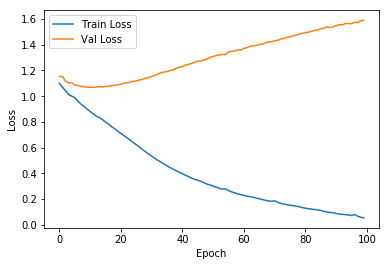

In [15]:
import matplotlib.pyplot as plt
def plot_loss_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(history.epoch, np.array(history.history['loss']),
               label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val Loss')
    plt.legend()
    #plt.ylim([0.05, 1])

plot_loss_history(history)

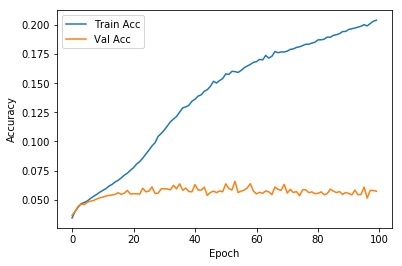

In [16]:
import matplotlib.pyplot as plt
def plot_loss_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(history.epoch, np.array(history.history['acc']),
               label='Train Acc')
    plt.plot(history.epoch, np.array(history.history['val_acc']),
           label = 'Val Acc')
    plt.legend()
    #plt.ylim([0.05, 1])

plot_loss_history(history)

In [0]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [0]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_word_index = dict(
    (i, word) for word, i in input_token_index.items())
reverse_target_word_index = dict(
    (i, word) for word, i in target_token_index.items())

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['START_']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while stop_condition == False:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = reverse_target_word_index[sampled_token_index]
        if (sampled_word != '_END'):
            decoded_sentence += ' '+sampled_word

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_word == '_END' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [20]:
from nltk.translate.bleu_score import sentence_bleu
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    target_sentence = target_texts[seq_index]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Target sentence:', target_sentence)
    print('Decoded sentence:', decoded_sentence)
    
    score = nltk.translate.bleu_score.sentence_bleu([target_sentence],decoded_sentence,weights =[1])
    print ('Bleuscore',score)

-
Input sentence: I do not want to die.
Target sentence: START_ मैं मरना नहीं चाहता. _END
Decoded sentence:  मैं मरना नहीं चाहता .
Bleuscore 0.6347364189402819
-
Input sentence: It's the same country I think.
Target sentence: START_ यह मुझे लगता है कि एक ही देश है. _END
Decoded sentence:  यह मुझे लगता है कि एक ही देश है .
Bleuscore 0.7451888170134805
-
Input sentence: Then they'll be crying like babies.
Target sentence: START_ फिर ये नन्हें बच्चों की तरह रोएँगे। _END
Decoded sentence:  ये ये उसका उसका नाम लिया है मुझे नहीं होता .
Bleuscore 0.4676362724503698
-
Input sentence: - No, I need power up!
Target sentence: START_ नहीं, मुझे पावर की जरुरत है ! _END
Decoded sentence:  नहीं , मुझे पावर की जरुरत है !
Bleuscore 0.7242775199742143
-
Input sentence: I will not eat him.
Target sentence: START_ मैं उसे नहीं खा जाएगा. _END
Decoded sentence:  मैं उसे नहीं खा जाएगा .
Bleuscore 0.6592406302004437
-
Input sentence: You gotta get me to Charleston.
Target sentence: START_ आप चार्ल्सटन करने के

In [0]:
ip_seq=[]
op_seq=[]
dec_seq=[]
b1=[]
b2=[]
b3=[]
b4=[]
b_cum=[]

In [22]:
# n-gram individual BLEU
from nltk.translate.bleu_score import sentence_bleu
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    target_sentence = target_texts[seq_index]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Target sentence:',target_sentence)
    print('Decoded sentence:','START_ '+decoded_sentence+' _END')
    x1=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(1, 0, 0, 0))
    print('Individual 1-gram: %f' % x1)
    x2=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0, 1, 0, 0))
    print('Individual 2-gram: %f' % x2)
    x3=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0, 0, 1, 0))
    print('Individual 3-gram: %f' % x3)
    x4=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0,0,0,1))
    print('Individual 4-gram: %f' % x4)
    score = sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0.25, 0.25, 0.25, 0.25))
    print('4-gram cummulative score: ',score)
    ip_seq.append(input_texts[seq_index])
    op_seq.append(target_sentence)
    dec_seq.append('START_ '+decoded_sentence+' _END')
    b1.append(x1)
    b2.append(x2)
    b3.append(x3)
    b4.append(x4)
    b_cum.append(score)

-
Input sentence: I do not want to die.
Target sentence: START_ मैं मरना नहीं चाहता. _END
Decoded sentence: START_  मैं मरना नहीं चाहता . _END
Individual 1-gram: 0.941176
Individual 2-gram: 0.909091
Individual 3-gram: 0.843750
Individual 4-gram: 0.774194
4-gram cummulative score:  0.8646402079563364
-
Input sentence: It's the same country I think.
Target sentence: START_ यह मुझे लगता है कि एक ही देश है. _END
Decoded sentence: START_  यह मुझे लगता है कि एक ही देश है . _END
Individual 1-gram: 0.956522
Individual 2-gram: 0.933333
Individual 3-gram: 0.886364
Individual 4-gram: 0.837209
4-gram cummulative score:  0.9021825013122124
-
Input sentence: Then they'll be crying like babies.
Target sentence: START_ फिर ये नन्हें बच्चों की तरह रोएँगे। _END
Decoded sentence: START_  ये ये उसका उसका नाम लिया है मुझे नहीं होता . _END
Individual 1-gram: 0.561404
Individual 2-gram: 0.267857
Individual 3-gram: 0.200000
Individual 4-gram: 0.129630
4-gram cummulative score:  0.24987807848117904
-
Input sen